In [1]:
%load_ext autoreload
%autoreload 2

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes
import math
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    SfMOrthographicCameras,
    PointLights, 
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    look_at_rotation
)

# add path for demo utils functions 
import sys
import os
import glob
sys.path.append(os.path.abspath(''))

from datetime import datetime
def now_str():
    now = datetime.now()
    month = str(now.month)
    day = str(now.day)
    hour = str(now.hour)
    minute = str(now.minute)
    sec = str(now.second)
    
    output = '[{:>02}/{:>02} {:>02}:{:>02}:{:>02}]'.format(month, day, hour, minute, sec)
    return output
print(now_str())

[03/31 15:28:19]


In [2]:
def reproject(params, vertices, distort=False):
    R = params['R']
    t = params['t']
    k1 = params['k1']
    k2 = params['k2']
    k3 = params['k3']
    p1 = params['p1']
    p2 = params['p2']
    fx = params['fx']
    fy = params['fy']
    cx = params['cx']
    cy = params['cy']
    f = (fx + fy) * 0.5

    E = np.array([
        [R[0,0], R[0,1], R[0,2], t[0]], 
        [R[1,0], R[1,1], R[1,2], t[1]], 
        [R[2,0], R[2,1], R[2,2], t[2]], 
        [0, 0, 0, 1]]).astype('double')

    img_pts = []
    for i in range(len(vertices)):
        v = np.array(vertices[i])

        # extrinsics
        v4 = E.dot(np.array([v[0], v[1], v[2], 1]).astype('double'))
        xp = v4[0] / v4[2]
        yp = v4[1] / v4[2]

        if distort:
            # intrinsics
            r2 = xp**2 + yp**2
            ## radial
            radial_dist = 1 + k1*(r2) + k2*(r2*r2) + k3*(r2*r2*r2)

            ## tangential
            tan_x = p2 * (r2 + 2.0 * xp * xp) + 2.0 * p1 * xp * yp
            tan_y = p1 * (r2 + 2.0 * yp * yp) + 2.0 * p2 * xp * yp

            xp = xp * radial_dist + tan_x
            yp = yp * radial_dist + tan_y
            
        u = f * xp + cx
        v = f * yp + cy
        pr = 1
        nr = 0
#         if (-4000*nr < u and u < pr*4000) and (-2160*nr < v and v < pr*2160):
        img_pts.append(np.array([u, v]))
    img_pts = np.array(img_pts)
    return img_pts

In [3]:
def reproject_pytorch(params, vertices, distort=False):
    # params is same as opencv convention
    R = params['R'].T
    T = params['t']
    k1 = params['k1']
    k2 = params['k2']
    k3 = params['k3']
    p1 = params['p1']
    p2 = params['p2']
    fx = params['fx']
    fy = params['fy']
    cx = params['cx']
    cy = params['cy']
    
    E = np.array([
        [R[0,0], R[0,1], R[0,2], 0], 
        [R[1,0], R[1,1], R[1,2], 0], 
        [R[2,0], R[2,1], R[2,2], 0], 
        [T[0], T[1], T[2], 1]]).astype('double')

    K = np.array([[fx, 0, 0, 0], [0, fy, 0, 0], [0, 0, 0, 1], [cx, cy, 1, 0]])
    
    img_pts = []
    for i in range(len(vertices)):
        v = np.array(vertices[i])

        # extrinsics
        v4 = np.array([v[0], v[1], v[2], 1]).astype('double').dot(E.dot(K))

        u = v4[0] / v4[3]
        v = v4[1] / v4[3]
        pr = 1
        nr = 0
        img_pts.append(np.array([u, v, v4[3]]))
    img_pts = np.array(img_pts)
    return img_pts

In [4]:
# Setup
#device = torch.device("cuda:0")
# torch.cuda.set_device(device)

device = torch.device("cpu")

target_texturemap_size = 1024
# images
img_dir = './4_data/input/2020_03_28_SMPL_UV/SMPL_registration/TPose'
mesh_dir = img_dir + '/../'

img_paths = glob.glob(img_dir + '/*.jpg')
image_refs_original = []
for path in img_paths:
    img = imageio.imread(path)
    image_refs_original.append(img)
print('{} images loaded: {}'.format(len(image_refs_original), image_refs_original[0].shape))

16 images loaded: (2160, 4000, 3)


In [5]:
# Load obj file
in_path = r'D:\1_Projects\200325_PyTorch3d_Toy\4_data\input\2020_03_28_SMPL_UV\SMPL_registration\SMPLFit_TPose.obj'
mesh = load_objs_as_meshes([in_path], device=device)
vs = mesh.verts_packed()
print(vs[0:3])
target_texturemap_shape = (target_texturemap_size, target_texturemap_size, 3)
texture_image = torch.from_numpy(np.ones((1, target_texturemap_shape[0], target_texturemap_shape[1], target_texturemap_shape[2])).astype(np.float32)).to(device)
# texture_image = mesh_texture
texture_image0 = mesh.textures.maps_padded()
print('Texturemap size: {}'.format(texture_image.shape))
print('Vertices:', mesh.verts_packed().shape)
print('Faces:', mesh.faces_packed().shape)
print(texture_image.is_cuda)

mesh_vertices = mesh.verts_packed().clone().cpu().numpy()
print(mesh_vertices.shape)
print(mesh_vertices[0:3])

tensor([[-354.0330,  207.6380, 1707.0809],
        [-356.3820,  195.7520, 1695.5021],
        [-346.1320,  204.9370, 1690.1910]])
Texturemap size: torch.Size([1, 1024, 1024, 3])
Vertices: torch.Size([6890, 3])
Faces: torch.Size([13776, 3])
False
(6890, 3)
[[-354.033    207.638   1707.0809 ]
 [-356.38202  195.752   1695.5021 ]
 [-346.13202  204.937   1690.191  ]]


In [6]:
cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']

in_path = r'D:\CalibrationData\CameraCalibration\2020_03_22_NewSuitDesignCapture\FinalCamParams\cam_params.json'
with open(in_path, 'r') as f:
    j = json.load(f)
    cam_params = j['cam_params']

sensor_size_mm = (22, 11.88)
cameras = []
composed_mtx = []
composed_mtx_pytorch = []
for cam_idx, cam in enumerate(cams):
    cam_param = cam_params[str(cam_idx)]
    # for undistortion
    fx = cam_param['fx']
    fy = cam_param['fy']
    cx = cam_param['cx']
    cy = cam_param['cy']
    k1 = cam_param['k1']
    k2 = cam_param['k2']
    p1 = cam_param['p1']
    p2 = cam_param['p2']
    k3 = cam_param['k3']
    
    # for undistortion
    K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
    K_pytorch = np.array([[fx, 0, 0, 0], [0, fy, 0, 0], [0, 0, 0, 1], [cx, cy, 1, 0]])

    rvec = np.float32(cam_param['rvec'])
    T = np.float32(cam_param['tvec'])
    R, _ = cv2.Rodrigues(rvec)
    
    # R = R.dot(R_z180)
    R_torch = torch.from_numpy(R.T).unsqueeze(0)
    T_torch = torch.from_numpy(T).unsqueeze(0)
    
    cam_params[str(cam_idx)]['R'] = R
    cam_params[str(cam_idx)]['t'] = T
    
    print('Camera {}'.format(cams[cam_idx]))
    principal_point = np.array([cx, cy]).astype(np.float32)
    principal_point = torch.from_numpy(principal_point).unsqueeze(0)
    
    # F(mm) = F(pixels) * SensorWidth(mm) / ImageWidth (pixel).
    # focal length in world units
    focal_length = np.array([fx, fy]).astype(np.float32)
#     focal_length[0] = focal_length[0] * sensor_size_mm[0] / 4000
#     focal_length[1] = focal_length[1] * sensor_size_mm[1] / 2160
    focal_length = torch.from_numpy(focal_length).unsqueeze(0)
    cameras.append(SfMPerspectiveCameras(device=device, R=R_torch, T=T_torch, principal_point=principal_point, focal_length=focal_length))
    
    E = np.array([[R[0, 0], R[0, 1], R[0, 2], T[0]],
                  [R[1, 0], R[1, 1], R[1, 2], T[1]], 
                  [R[2, 0], R[2, 1], R[2, 2], T[2]]]).astype(np.float32)
    E_pytorch = np.array([[R_torch[0][0, 0], R_torch[0][0, 1], R_torch[0][0, 2], 0], 
                          [R_torch[0][1, 0], R_torch[0][1, 1], R_torch[0][1, 2], 0],
                          [R_torch[0][2, 0], R_torch[0][2, 1], R_torch[0][2, 2], 0], 
                          [T_torch[0][0], T_torch[0][1], T_torch[0][2], 1]]).astype(np.float32)
    composed_mtx.append({'E': E, 'K': K, 'KE': K.dot(E)})
    composed_mtx_pytorch.append({'E': E_pytorch, 'K': K_pytorch, 'KE': E_pytorch.dot(K_pytorch)})
    
R, T = look_at_view_transform(2.7, 0, 180) 
cameras_test = OpenGLPerspectiveCameras(device=device, R=R, T=T)

Camera A
Camera B
Camera C
Camera D
Camera E
Camera F
Camera G
Camera H
Camera I
Camera J
Camera K
Camera L
Camera M
Camera N
Camera O
Camera P


# Check R from ours and Pytorch

In [7]:
cam_idx = 0
E = cameras[cam_idx].get_world_to_view_transform()
K = cameras[cam_idx].get_projection_transform()
print('Extrinsics==========================')
print('pytorch')
print(E.get_matrix().cpu().numpy()[0])
print(composed_mtx_pytorch[cam_idx]['E'])
print('opencv')
print(composed_mtx[cam_idx]['E'])
print()
print('Intrinsics==========================')
print('pytorch')
print(K.get_matrix().cpu().numpy()[0])
print(composed_mtx_pytorch[cam_idx]['K'])
print('opencv')
print(composed_mtx[cam_idx]['K'])

Extrinsics==========================
pytorch
[[-9.9486917e-01 -5.8328386e-02  8.2662545e-02  0.0000000e+00]
 [-9.8569624e-02  3.7479469e-01 -9.2185301e-01  0.0000000e+00]
 [ 2.2788716e-02 -9.2527115e-01 -3.7862107e-01  0.0000000e+00]
 [-2.9143100e+02  5.3828900e+02  2.8475901e+03  1.0000000e+00]]
[[-9.9486917e-01 -5.8328386e-02  8.2662545e-02  0.0000000e+00]
 [-9.8569624e-02  3.7479469e-01 -9.2185301e-01  0.0000000e+00]
 [ 2.2788716e-02 -9.2527115e-01 -3.7862107e-01  0.0000000e+00]
 [-2.9143100e+02  5.3828900e+02  2.8475901e+03  1.0000000e+00]]
opencv
[[-9.9486917e-01 -9.8569624e-02  2.2788716e-02 -2.9143100e+02]
 [-5.8328386e-02  3.7479469e-01 -9.2527115e-01  5.3828900e+02]
 [ 8.2662545e-02 -9.2185301e-01 -3.7862107e-01  2.8475901e+03]]

Intrinsics==========================
pytorch
[[1.90408e+03 0.00000e+00 0.00000e+00 0.00000e+00]
 [0.00000e+00 1.90132e+03 0.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00]
 [1.95754e+03 1.09990e+03 1.00000e+00 0.00000e+00]]
[

In [8]:
KE = cameras[cam_idx].get_full_projection_transform()
print('KE==========================')
print('pytorch')
print(KE.get_matrix().cpu().numpy()[0])
print(composed_mtx_pytorch[cam_idx]['KE'])
print('opencv')
print(composed_mtx[cam_idx]['KE'])
print()

KE==========================
pytorch
[[-1.89431042e+03 -1.10900925e+02  0.00000000e+00  8.26625451e-02]
 [-1.87684448e+02  7.12604614e+02  0.00000000e+00 -9.21853006e-01]
 [ 4.33915367e+01 -1.75923645e+03  0.00000000e+00 -3.78621072e-01]
 [-5.52950375e+05  1.02455950e+06  1.00000000e+00  2.84759009e+03]]
[[-1.89431049e+03 -1.10900928e+02  0.00000000e+00  8.26625451e-02]
 [-1.87684450e+02  7.12604643e+02  0.00000000e+00 -9.21853006e-01]
 [ 4.33915393e+01 -1.75923655e+03  0.00000000e+00 -3.78621072e-01]
 [-5.52950398e+05  1.02455954e+06  1.00000000e+00  2.84759009e+03]]
opencv
[[-1.73249526e+03 -1.99224858e+03 -6.97774353e+02  5.01936356e+06]
 [-1.99803942e+01 -3.01341478e+02 -2.17568187e+03  4.15552398e+06]
 [ 8.26625451e-02 -9.21853006e-01 -3.78621072e-01  2.84759009e+03]]



## Reprojection

In [9]:
mesh_points = []
mesh_points_pytorch = []
for cam_idx in range(16):
    params = cam_params[str(cam_idx)]
    print('------- camera {} -------------------'.format(cam_idx))
    print('input:', mesh_vertices[0, :])
    pts = reproject(params, mesh_vertices, distort=False)
    pts_pytorch = reproject_pytorch(params, mesh_vertices, distort=False)
    mesh_points.append(pts)
    mesh_points_pytorch.append(pts_pytorch)
    
    print('outout:')
    print('  opencv:', pts[0, :])
    print('  pytorch:', pts_pytorch[0, :])
print(pts.shape)
print(len(mesh_points))
print(mesh_points[0][0:3])

------- camera 0 -------------------
input: [-354.033   207.638  1707.0809]
outout:
  opencv: [2033.64592452  194.21707375]
  pytorch: [  77.14949191 -904.47070449 1980.57629305]
------- camera 1 -------------------
input: [-354.033   207.638  1707.0809]
outout:
  opencv: [2111.23781271  280.61395375]
  pytorch: [  81.79415514 -823.73099343 2052.0734738 ]
------- camera 2 -------------------
input: [-354.033   207.638  1707.0809]
outout:
  opencv: [2236.9904819   241.60685037]
  pytorch: [ 249.74767879 -871.76005273 1982.83672138]
------- camera 3 -------------------
input: [-354.033   207.638  1707.0809]
outout:
  opencv: [2115.49469073  252.82965806]
  pytorch: [  87.98420218 -897.76169016 1974.52786092]
------- camera 4 -------------------
input: [-354.033   207.638  1707.0809]
outout:
  opencv: [1964.97514828  216.31546541]
  pytorch: [ -43.78351548 -868.85535814 2010.87566234]
------- camera 5 -------------------
input: [-354.033   207.638  1707.0809]
outout:
  opencv: [2100.25047

### Recover pytorch [u, v] to [x_c, y_c, z_c] then back to [u, v] using OpenCV convention

In [10]:
mesh_pts_pytorch2opencv = []
for i in range(16):
    KE = composed_mtx_pytorch[i]['KE']
    K = composed_mtx_pytorch[i]['K']
    fx = K[0, 0]
    fy = K[1, 1]
    cx = K[3, 0]
    cy = K[3, 1]
    
    uv = mesh_points_pytorch[i].copy()
    Zc = uv[:, 2]
    u = uv[:, 0]
    v = uv[:, 1]
    
    # if fx, fy were scaled differently for pytorch than opencv:
#     u *= 0.001
#     v *= 0.001
    
    if i==0:
        print(uv[0, :])
    
    # back to 3d point in camera coordinates system
    Xc = (Zc*u-cx)/fx
    Yc = (Zc*v-cy)/fy
    
    # back to 3d point in world coordinate system (redundant)
#     KE_cv = composed_mtx[i]['KE']
#     # back to world coordinates & reproject
#     pts = []
#     for j in range(Zc.shape[0]):
#         Pc = np.array([Xc[j], Yc[j], 1, Zc[j]])
#         Pw = Pc.dot(np.linalg.inv(KE))[0:3]
#         if i == 0 and j == 0:
#             print(Xc[0], ',', Yc[0], ',', Zc[0])
#             print(Pw)
#         pts.append(Pw)
#     pts = np.array(pts)
#     uvs = reproject(cam_params[str(i)], pts, distort=False)

    # from camera -> image coordinates system
    u = fx*(Xc/Zc)+cx
    v = fy*(Yc/Zc)+cy
    uvs = np.stack([u, v]).T
    
    mesh_pts_pytorch2opencv.append(uvs)

for i in range(16):
    print('[{}] from :'.format(i), mesh_points_pytorch[i][0, :])
    print('     to   :', mesh_pts_pytorch2opencv[i][0, :])
    print('     equal:', mesh_points[i][0, :])

[  77.14949191 -904.47070449 1980.57629305]
[0] from : [  77.14949191 -904.47070449 1980.57629305]
     to   : [2033.70112301  194.8739521 ]
     equal: [2033.64592452  194.21707375]
[1] from : [  81.79415514 -823.73099343 2052.0734738 ]
     to   : [2111.27468278  280.99040012]
     equal: [2111.23781271  280.61395375]
[2] from : [ 249.74767879 -871.76005273 1982.83672138]
     to   : [2237.06491342  241.8680301 ]
     equal: [2236.9904819   241.60685037]
[3] from : [  87.98420218 -897.76169016 1974.52786092]
     to   : [2115.50684265  252.95523375]
     equal: [2115.49469073  252.82965806]
[4] from : [ -43.78351548 -868.85535814 2010.87566234]
     to   : [1964.98703436  216.08483723]
     equal: [1964.97514828  216.31546541]
[5] from : [ 127.0382945  -790.75337867 2039.93038896]
     to   : [2100.24053108  285.53875037]
     equal: [2100.25047858  285.60117592]
[6] from : [ -30.27396891 -849.95080636 2058.61120859]
     to   : [1942.29736051  245.59675701]
     equal: [1942.2738924

w=1080.0, h=1080.0
1.0


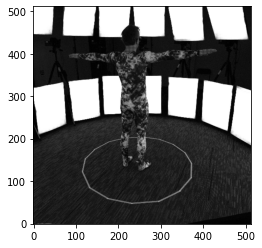

In [11]:
w = 2160/2
h = 2160/2
rendered_image_size = 512

print('w={}, h={}'.format(w, h))
image_refs = []
for i in range(len(image_refs_original)):
    cam = cam_params[str(i)]
    pts = mesh_points[i]
    image_center = np.mean(pts, axis=0)
#     cx = image_center[0]
#     cy = image_center[1]
    cx = 2000
    cy = 1080
    image = image_refs_original[i]
    img = image[:, int(cx-w):int(cx+w)]
    img = cv2.resize(img, (rendered_image_size, rendered_image_size))
    img = cv2.flip(img, -1)
    img = img / 255.0
    image_refs.append(img)
print(np.max(img))
plt.imshow(img)
plt.gca().invert_yaxis()

In [12]:
raster_settings = RasterizationSettings(
    image_size=rendered_image_size, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    bin_size = None,  # this setting controls whether naive or coarse-to-fine rasterization is used
    max_faces_per_bin = None  # this setting is for coarse rasterization
)

renderers = []
for i in range(len(cameras)):
    camera = cameras[i]
    cam_pos = camera.T[0]
    lights = PointLights(device=device, location=[[cam_pos[0], cam_pos[1], cam_pos[2]]])
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=camera,
            raster_settings=raster_settings
        ),
        shader=TexturedSoftPhongShader(
            device=device, 
            cameras=camera,
            lights=lights
        )
    )
    renderers.append(renderer)

In [13]:
print('Rendering:')
images_rendered = []
for i, renderer in enumerate(renderers):
    print('-------------------------------------------------')
    print(' {}/{}'.format(i+1, len(renderers)), end='')
    images = renderer(mesh, texture_maps=texture_image)
    pts = mesh_vertices[0:3]
    pts1 = []
    for j in range(pts.shape[0]):
        p = composed_mtx[i]['KE'].dot(np.array([pts[j][0], pts[j][1], pts[j][2], 1]))
        pts1.append(p)
    images = images[0, ..., :3].cpu().numpy()
    images_rendered.append(images)
print()
print('{} images rendered'.format(len(images_rendered)))

Rendering:
-------------------------------------------------
 1/16-------------------------------------------------
 2/16-------------------------------------------------
 3/16-------------------------------------------------
 4/16-------------------------------------------------
 5/16-------------------------------------------------
 6/16-------------------------------------------------
 7/16-------------------------------------------------
 8/16-------------------------------------------------
 9/16-------------------------------------------------
 10/16-------------------------------------------------
 11/16-------------------------------------------------
 12/16-------------------------------------------------
 13/16-------------------------------------------------
 14/16-------------------------------------------------
 15/16-------------------------------------------------
 16/16
16 images rendered


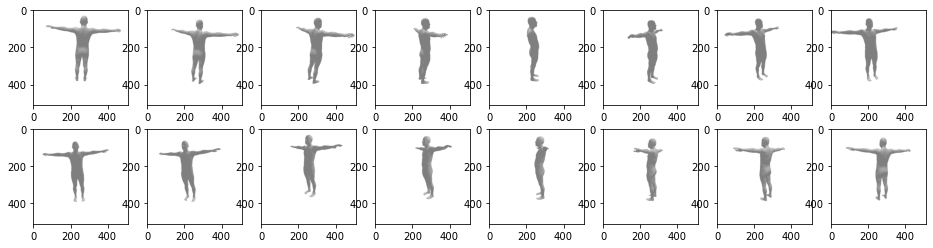

In [14]:
fig, ax = plt.subplots(2, 8, figsize=(16, 4))
ax = ax.ravel()
for i in range(len(ax)):
    a = ax[i]
    img = cv2.flip(images_rendered[i], -1)
    a.imshow(img)
plt.show()

rendered_image_size: 512


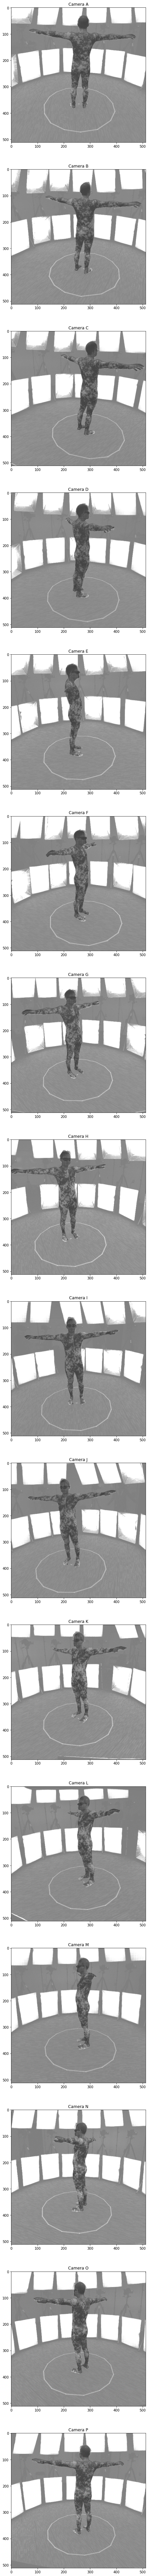

In [15]:
%matplotlib inline
fig, ax = plt.subplots(16, 1, figsize=(15, 140))
ax = ax.ravel()
print('rendered_image_size:', rendered_image_size)
for i in range(len(ax)):
#     ax[i].imshow(image_refs_original[i])
    img_mesh = images_rendered[i]
    img_mesh = cv2.flip(img_mesh, -1)
    img_bg = image_refs[i]
    img_bg = cv2.flip(img_bg, -1)
    ax[i].imshow(img_bg)

    img_mesh_large = np.zeros(img_bg.shape)
    img_mesh_padded = cv2.copyMakeBorder(img_mesh, 0, 0, int((4000-2160)/2), int((4000-2160)/2), 0, None, [0, 0, 0])
    ax[i].imshow(img_mesh, alpha=0.5)
    
    if len(mesh_points[i]) < 1:
        continue
    pts = mesh_points[i].copy()
    pts_small_x = (pts[:, 0] - (4000-2160)*0.5) * rendered_image_size/2160
    pts_small_y = pts[:, 1] * rendered_image_size/2160
    pts_small = np.stack([pts_small_x, pts_small_y]).T
#     ax[i].scatter(pts_small[:, 0], pts_small[:, 1], c='r', s=0.1)

#     pts = mesh_points_pytorch[i].copy()
#     p = rendered_image_size/2
#     pts *= rendered_image_size/2160
#     pts += p
#     ax[i].scatter(pts[:, 0], pts[:, 1], c='b', s=0.01)
#     ax[i].plot([-p, -p], [p, -p], c='k')
#     ax[i].plot([p, -p], [p, p], c='k')
#     ax[i].plot([p, p], [-p, p], c='k')
#     ax[i].plot([-p, p], [-p, -p], c='k')
    
    ax[i].set_title('Camera {}'.format(cams[i]))

    # recovered pts
    pts = mesh_pts_pytorch2opencv[i].copy()  
    pts[:, 0] = (pts[:, 0] - (4000-2160)*0.5) * rendered_image_size/2160
    pts[:, 1] = pts[:, 1] * rendered_image_size/2160 
#     ax[i].scatter(pts[:, 0], pts[:, 1], c='g', s=0.01)
#     ax[i].set_xlim([0, 4000])
#     ax[i].set_ylim([0, 2160])
#     ax[i].invert_yaxis()

# check world->view

In [16]:
def print_mtx(M, row_major=True):
    if row_major:
        for r in range(M.shape[0]):
            for c in range(M.shape[1]):
                print(' {:>10} |'.format('{:.4f}'.format(M[r, c])), end='')
            print()
    else:
        for c in range(M.shape[1]):
            for r in range(M.shape[0]):
                print(' {:>10} |'.format('{:.4f}'.format(M[r, c])), end='')
            print()
            
p1 = np.float32([-354.0330,  207.6380, 1707.0809, 1.0000])
p2 = np.float32([0, 0, 0, 1.0])


In [17]:
cam_idx = 0
c = cameras[cam_idx]

# world -> view -> screen
projection_transform = c.get_projection_transform()
world_to_view_transform = c.get_world_to_view_transform()
full_projection_transform = c.get_full_projection_transform()

view2screen = projection_transform.get_matrix().cpu().numpy()[0]
world2view = world_to_view_transform.get_matrix().cpu().numpy()[0]
world2screen = full_projection_transform.get_matrix().cpu().numpy()[0]

E = composed_mtx[cam_idx]['E']
K = composed_mtx[cam_idx]['K']
KE = composed_mtx[cam_idx]['KE']
print('Extrinsics ----------------------------------------------------------------')
print_mtx(world2view, True)
print()
print_mtx(E, True)
print('~~~~ pytorch')
wp1 = p1.dot(world2view)
wp2 = p2.dot(world2view)
print('in:')
print_mtx(np.expand_dims(p1, axis=0))
print_mtx(np.expand_dims(p2, axis=0))
print('out:')
print_mtx(np.expand_dims(wp1, axis=0))
print_mtx(np.expand_dims(wp2, axis=0))
print()
print('~~~~ ours')
wp1 = E.dot(p1)
wp2 = E.dot(p2)
print('in:')
print_mtx(np.expand_dims(p1, axis=0))
print_mtx(np.expand_dims(p2, axis=0))
print('out:')
print_mtx(np.expand_dims(wp1, axis=0))
print_mtx(np.expand_dims(wp2, axis=0))
print()
print('Intrinsics ----------------------------------------------------------------')
print_mtx(view2screen, True)
print()
print_mtx(K, True)
print()
print('Composed ----------------------------------------------------------------')
print_mtx(world2screen, True)
print()
print_mtx(KE, True)
print('~~~~ pytorch')
wp1 = p1.dot(world2screen)
wp2 = p2.dot(world2screen)
print('out:')
print_mtx(np.expand_dims(wp1, axis=0))
print_mtx(np.expand_dims(wp2, axis=0))
print('  out1: [{:.4f}, {:4f}]'.format(wp1[0]/wp1[3], wp1[1]/wp1[3]))
print('  out2: [{:.4f}, {:4f}]'.format(wp2[0]/wp2[3], wp2[1]/wp2[3]))
print('~~~~ ours')
wp1 = KE.dot(p1)
wp2 = KE.dot(p2)
print('out:')
print_mtx(np.expand_dims(wp1, axis=0))
print_mtx(np.expand_dims(wp2, axis=0))
print('  out1: [{:.4f}, {:4f}]'.format(wp1[0]/wp1[3], wp1[1]/wp1[3]))
print('  out2: [{:.4f}, {:4f}]'.format(wp2[0]/wp2[3], wp2[1]/wp2[3]))
print()

Extrinsics ----------------------------------------------------------------
    -0.9949 |    -0.0583 |     0.0827 |     0.0000 |
    -0.0986 |     0.3748 |    -0.9219 |     0.0000 |
     0.0228 |    -0.9253 |    -0.3786 |     0.0000 |
  -291.4310 |   538.2890 |  2847.5901 |     1.0000 |

    -0.9949 |    -0.0986 |     0.0228 |  -291.4310 |
    -0.0583 |     0.3748 |    -0.9253 |   538.2890 |
     0.0827 |    -0.9219 |    -0.3786 |  2847.5901 |
~~~~ pytorch
in:
  -354.0330 |   207.6380 |  1707.0809 |     1.0000 |
     0.0000 |     0.0000 |     0.0000 |     1.0000 |
out:
    79.2209 |  -942.7519 |  1980.5763 |     1.0000 |
  -291.4310 |   538.2890 |  2847.5901 |     1.0000 |

~~~~ ours
in:
  -354.0330 |   207.6380 |  1707.0809 |     1.0000 |
     0.0000 |     0.0000 |     0.0000 |     1.0000 |
out:
    79.2209 |  -942.7518 |  1980.5764 |
  -291.4310 |   538.2890 |  2847.5901 |

Intrinsics ----------------------------------------------------------------
  1904.0800 |     0.0000 |     0.00

IndexError: index 3 is out of bounds for axis 0 with size 3

In [ ]:
#  158978.6250 | -1779212.7500 |     1.0000 |  1995.7233 |
#  137607.6250 | -1764460.7500 |     1.0000 |  1990.1143 |